# This code is to get the labeled_energy_data csv file of each model

## 对数据进行分析,展示出来的内容包括:
### 1. 每个模型在 5 个 epochs 下的每个能耗数据点

## Import the lib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

## Function in use

### load the interpolate function

In [3]:
def integrate_power_over_interval(samples, start_time, end_time):
    # 假定 samples是按时间升序排序的 (t, p)
    # 若未排序，请先排序:
    # samples = sorted(samples, key=lambda x: x[0])
    
    def interpolate(samples, target_time):
        # 在 samples 中找到 target_time 左右最近的两个点，并进行线性插值
        # 若 target_time 恰好等于某个样本点时间，直接返回该点功率
        # 若无法找到两侧点（如 target_time在样本时间轴外），根据情况返回None或边界点
        n = len(samples)
        if n == 0:
            return None
        # 若 target_time 小于第一个样本点时间，无法向左插值，这里直接返回第一个点的功率值(或None)
        if target_time <= samples[0][0]:
            # 简化处理：返回最早样本点的功率（或None）
            return samples[0][1]
        # 若 target_time 大于最后一个样本点时间，无法向右插值，返回最后一个点的功率（或None）
        if target_time >= samples[-1][0]:
            return samples[-1][1]

        # 否则，在中间插值
        # 使用二分查找快速定位
        import bisect
        times = [t for t, _ in samples]
        pos = bisect.bisect_left(times, target_time)
        # pos是使times保持有序插入target_time的位置
        # 因为target_time不在已有样本点中，pos不会越界且pos>0且pos<n
        t1, p1 = samples[pos-1]
        t2, p2 = samples[pos]
        # 线性插值： p = p1 + (p2 - p1)*((target_time - t1)/(t2 - t1))
        ratio = (target_time - t1) / (t2 - t1)
        p = p1 + (p2 - p1)*ratio
        return p

    # 从原始 samples 中筛选出位于[start_time, end_time]内的点
    filtered = [(t, p) for t, p in samples if start_time <= t <= end_time]

    # 如果不足2个点，则尝试使用插值
    if len(filtered) < 2:
        # 无论如何都需要在边界处插值出两个点(起码start和end)
        start_power = interpolate(samples, start_time)
        end_power = interpolate(samples, end_time)

        # 如果从样本中无法插值出任何有意义的点（比如samples为空或无法插值），返回0.0
        if start_power is None or end_power is None:
            return 0.0

        # 将插值的边界点加入到 filtered
        # 注意：如果filtered中有一个点在区间内，我们也需要确保边界有两点以上
        # 例如filtered只有一个点在中间，则需要在start和end插值点全部加入。
        # 若filtered为空，则只用start/end两点插值点求积分
        new_filtered = [(start_time, start_power)] + filtered + [(end_time, end_power)]
        # 确保按时间排序
        new_filtered.sort(key=lambda x: x[0])
        filtered = new_filtered

    # 正常积分计算
    if len(filtered) < 2:
        # 经过插值仍不够，返回0
        return 0.0

    total_energy = 0.0
    for i in range(len(filtered)-1):
        t1, p1 = filtered[i]
        t2, p2 = filtered[i+1]
        dt = t2 - t1
        avg_p = (p1 + p2)/2.0
        total_energy += avg_p * dt

    return total_energy

### Read the data

In [4]:
def load_data(model_path):
    # load the csv files 
    energy_data = pd.read_csv(os.path.join(model_path, 'energy_consumption_file.csv'))
    labeled_energy_data = pd.read_csv(os.path.join(model_path, 'labeled_energy_data.csv'))
    forward_layer_energy = pd.read_csv(os.path.join(model_path, 'layer_energy.csv'))

    # load the npy files
    to_device = np.load(os.path.join(model_path, 'to_device.npy'), allow_pickle=True)
    loss = np.load(os.path.join(model_path, 'loss.npy'), allow_pickle=True)
    backward = np.load(os.path.join(model_path, 'backward.npy'), allow_pickle=True)
    optimize = np.load(os.path.join(model_path, 'optimize.npy'), allow_pickle=True)

    # load the energy data
    to_device_energy = np.load(os.path.join(model_path, 'to_device_energy.npy'), allow_pickle=True)
    forward_energy = np.load(os.path.join(model_path, 'forward_energy.npy'), allow_pickle=True)
    loss_energy = np.load(os.path.join(model_path, 'loss_energy.npy'), allow_pickle=True)
    backward_energy = np.load(os.path.join(model_path, 'backward_energy.npy'), allow_pickle=True)
    optimize_energy = np.load(os.path.join(model_path, 'optimize_energy.npy'), allow_pickle=True)
    
    return energy_data, labeled_energy_data, forward_layer_energy, \
            to_device, loss, backward, optimize, \
            to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy

### preprocess the data

In [5]:
'''1. get the energy consumption of each layer as well as the forward step energy'''
# get the layer energy consumption into a ndarray
def get_layer_energy(forward_layer_energy, model_path):

    # get the layer names as a list
    # find out the layer names from a batch
    layer_data = forward_layer_energy.iloc[0][0]
    # transfer the string to a dictionary
    layer_data_dic = eval(layer_data)
    # get the layer names
    layer_names = layer_data_dic.keys()
    # transfer the layer names to a list
    layer_names = list(layer_names)
    print('layer_names:', layer_names)

    # print the shape of the forward_layer_energy
    print('The shape of the forward_layer_energy:', forward_layer_energy.shape[0], forward_layer_energy.shape[1])

    # create a ndarray to store the layer energy, the shape is (num_batches_total, num_layers)
    layer_energy = np.zeros((forward_layer_energy.shape[0]* forward_layer_energy.shape[1], len(layer_names)))
    print('The shape of the layer_energy:', layer_energy.shape)

    # # create a ndarray to store the forward step energy, the shape is (num_batches_total, 3)
    # # the first is the forward start time, the second is the forward end time, the third is the forward energy
    # forward_energy = np.zeros((forward_layer_energy.shape[0]* forward_layer_energy.shape[1], 3))
    # print('The shape of the layer_energy:', forward_energy.shape)

    # iterate the column of the csv file, which is the epoch number
    for i in range(forward_layer_energy.shape[1]):
        # iterate the row of the csv file, which is the batch number
        for j in range(forward_layer_energy.shape[0]):
            batch_layer = forward_layer_energy.iloc[j][str(i)]
            batch_layer = eval(batch_layer)
            # print(f'The batch number is {j}, the epoch number is {i}')
            # print(batch_layer)
            # get the first dictionary value of the batch_layer
            # forward_start_time = list(batch_layer.values())[0][0]
            # get the last dictionary value of the batch_layer
            # forward_end_time = list(batch_layer.values())[-1][1]
            # forward_energy_batch = 0
            for layer_name, layer_energy_value in batch_layer.items():
                layer_idx = list(layer_names).index(layer_name)
                row_num = i*forward_layer_energy.shape[0]+j
                # print(f'The row number is {row_num}, the layer index is {layer_idx}')
                layer_energy[row_num, layer_idx] = layer_energy_value[-1]
                # forward_energy_batch += layer_energy_value[-1]
            # forward_energy[i*forward_layer_energy.shape[0]+j, 0] = forward_start_time
            # forward_energy[i*forward_layer_energy.shape[0]+j, 1] = forward_end_time
            # forward_energy[i*forward_layer_energy.shape[0]+j, 2] = forward_energy_batch

    # # transfer the shape of the forward_energy to (num_of_epochs, num_of_batches, 3)
    # forward_energy = forward_energy.reshape((forward_layer_energy.shape[1], forward_layer_energy.shape[0], 3))
    # print('The shape of the layer_energy:', forward_energy.shape)
    
    # # save the forward energy to a npy file, the path is model_path
    # np.save(os.path.join(model_path, 'forward_energy.npy'), forward_energy)

    
    # return layer_names, layer_energy, forward_energy
    return layer_names, layer_energy 

### preset the color and marker

In [6]:
# Create a color map and marker map for the steps
step_colors = {
    'idle': 'gray',
    'to_device': 'blue',
    'forward': 'green',
    'loss': 'red',
    'backward': 'purple',
    'optimize': 'orange'
}
step_markers = {
    'idle': 'o',
    'to_device': 's',
    'forward': '^',
    'loss': 'D',
    'backward': 'x',
    'optimize': 'P'
}

### Plot the energy data of each sample with scatter plot and line plot

In [7]:
def plot_energy_data(labeled_energy_data):
    # Plot the data with a larger figure size
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each step with a different marker
    for step in step_colors.keys():
        step_data = labeled_energy_data[labeled_energy_data['step'] == step]
        if step != 'idle':
            ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step, s=5, marker=step_markers[step])

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Power in Watts')
    ax.legend()
    plt.show()

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12,6))

    # Plot each step with a different color
    for step in step_colors.keys():
        step_data = labeled_energy_data[labeled_energy_data['step'] == step]
        if step != 'idle':
            ax.plot(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Power in Watts')
    ax.legend()
    plt.show()

### Plot the energy data of a time period with scatter plot

In [8]:
def plot_period_energy_data(labeled_energy_data):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12,8))

    labeled_energy_data_rows = labeled_energy_data[210000:219200]
    # Plot each step with a different color, except 'optimize' and 'loss'
    for step in step_colors.keys():
        if step != 'idle':
            if step not in ['optimize', 'loss']:
                step_data = labeled_energy_data_rows[labeled_energy_data_rows['step'] == step]
                ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

    # Plot 'optimize' and 'loss' steps last to ensure they are on top
    for step in ['optimize', 'loss']:
        step_data = labeled_energy_data_rows[labeled_energy_data_rows['step'] == step]
        ax.scatter(step_data['timestamp'], step_data['power_in_watts'], color=step_colors[step], label=step)

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Power in Watts')
    ax.legend()
    plt.show()

### plot each step energy data in each batch

In [9]:
def plot_batch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    batch_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # print out the shape of the energy_consumption
    print('The shape of the to_device_energy:', to_device_energy.shape)
    print('The shape of the forward_energy:', forward_energy.shape)
    print('The shape of the loss_energy:', loss_energy.shape)
    print('The shape of the backward_energy:', backward_energy.shape)
    print('The shape of the optimize_energy:', optimize_energy.shape)

    # plot the energy consumption for each step
    fig, ax = plt.subplots(figsize=(10,6))
    for step in batch_info:
        energy_data = energy_data_dict[step]
        energy_consumption = [energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]
        ax.plot(range(len(energy_consumption)), energy_consumption, color=step_colors[step], label=step)

    ax.set_xlabel('Batch Index(Total 5 Epochs)')
    ax.set_ylabel('Energy Consumption per batch in Joules')
    ax.legend()
    plt.show()

### plot each step energy data with all batch with the x axis set to each step

In [10]:
def plot_step_energy_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    batch_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # plot the energy consumption for each step using dots
    fig, ax = plt.subplots(figsize=(10, 6))

    # Calculate the average energy consumption for each step
    average_energy_consumption = {step: np.mean([energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]) for step, energy_data in energy_data_dict.items()}

    # Plot each step's energy consumption as a dot on the corresponding x-axis
    for i, step in enumerate(batch_info):
        energy_data = energy_data_dict[step]
        energy_consumption = [energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]
        ax.scatter([i] * len(energy_consumption), energy_consumption, color=step_colors[step], label=step, marker='o')

    # Set the x-axis labels to the batch_info
    ax.set_xticks(range(len(batch_info)))
    ax.set_xticklabels(batch_info)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Energy Consumption per batch in Joules')
    ax.legend()
    plt.show()

### plot each step mean and std energy data with all batch with the x axis set to each step

In [11]:
def plot_step_energy_distribution_bar(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    # Use a more subtle color palette
    step_colors = {
        'idle': '#999999',  # light gray
        'to_device': '#1f77b4',  # muted blue
        'forward': '#2ca02c',  # muted green
        'loss': '#d62728',  # muted red
        'backward': '#9467bd',  # muted purple
        'optimize': '#ff7f0e'  # muted orange
    }

    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # Calculate the mean and standard deviation for each step
    mean_energy_consumption = {step: np.mean([energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]) for step, energy_data in energy_data_dict.items()}
    std_energy_consumption = {step: np.std([energy_data[epoch][batch][2] for epoch in range(to_device_energy.shape[0]) for batch in range(to_device_energy.shape[1])]) for step, energy_data in energy_data_dict.items()}

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the mean energy consumption with error bars representing the standard deviation
    steps = list(mean_energy_consumption.keys())
    means = list(mean_energy_consumption.values())
    stds = list(std_energy_consumption.values())

    ax.bar(steps, means, yerr=stds, capsize=5, color=[step_colors[step] for step in steps])

    # Set the x-axis and y-axis labels and title
    ax.set_xlabel('Steps', fontsize=14)
    ax.set_ylabel('Energy Consumption per batch in Joules', fontsize=14)
    ax.set_title('Mean and Standard Deviation of Energy Consumption for Each Step in 1 Batch', fontsize=16)

    # Improve the layout and aesthetics
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

### plot each step time consumption with all batch with the x axis set to each batch

In [12]:
def plot_step_time_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    batch_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }

    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot time duration for each step
    for step in batch_info:
        energy_data = energy_data_dict[step]
        # Calculate time duration (end_time - start_time) for each batch
        time_durations = [energy_data[epoch][batch][1] - energy_data[epoch][batch][0] 
                         for epoch in range(energy_data.shape[0]) 
                         for batch in range(energy_data.shape[1])]
        
        # Plot with corresponding color from step_colors
        ax.plot(range(len(time_durations)), time_durations, 
                color=step_colors[step], label=step)

    # set the y-axis from 0 to 0.1
    ax.set_ylim(0, 0.07)

    ax.set_xlabel('Batch Index (Total 5 Epochs)')
    ax.set_ylabel('Time Duration (seconds)')
    ax.set_title('Time Consumption per Step across Batches')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.show()

### plot each step time consumption with all batch with the x axis set to each step

In [13]:
def plot_step_time_distribution_box(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    # Create a dictionary to store time durations for each step
    step_times = {
        'to_device': [],
        'forward': [],
        'loss': [],
        'backward': [],
        'optimize': []
    }
    
    # Calculate time durations for each step
    energy_data_dict = {
        'to_device': to_device_energy,
        'forward': forward_energy,
        'loss': loss_energy,
        'backward': backward_energy,
        'optimize': optimize_energy
    }
    
    for step, energy_data in energy_data_dict.items():
        time_durations = [energy_data[epoch][batch][1] - energy_data[epoch][batch][0] 
                         for epoch in range(energy_data.shape[0]) 
                         for batch in range(energy_data.shape[1])]
        step_times[step] = time_durations

    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Create scatter plot for each step
    for i, (step, times) in enumerate(step_times.items(), 1):
        plt.scatter([i] * len(times), times, color=step_colors[step], 
                   alpha=0.6, label=step, marker=step_markers[step])

    # set the y-axis from 0 to 0.1
    plt.ylim(0, 0.07)

    # Customize plot
    plt.xticks(range(1, len(step_times) + 1), list(step_times.keys()), rotation=45)
    plt.ylabel('Time Duration (seconds)')
    plt.title('Distribution of Time Consumption per Step')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()


### plot each step total energy data with all batch with the x axis set to each step in each epoch

In [14]:
# calculate the energy consumption for each step in each epoch
def cal_energy_epoch(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    energy_step_epoch = np.zeros((to_device_energy.shape[0], 5))
    for epoch in range(to_device_energy.shape[0]):
        for batch in range(to_device_energy.shape[1]):
            energy_step_epoch[epoch][0] += to_device_energy[epoch][batch][2]
            energy_step_epoch[epoch][1] += forward_energy[epoch][batch][2]
            energy_step_epoch[epoch][2] += loss_energy[epoch][batch][2]
            energy_step_epoch[epoch][3] += backward_energy[epoch][batch][2]
            energy_step_epoch[epoch][4] += optimize_energy[epoch][batch][2]
    return energy_step_epoch

def plot_epoch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    energy_step_epoch = cal_energy_epoch(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    print(energy_step_epoch)
    step_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    num_epochs = energy_step_epoch.shape[0]
    bar_width = 0.15  # Width of each bar

    # Use a color palette for epochs
    epoch_colors = plt.cm.viridis(np.linspace(0, 1, num_epochs))

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the energy consumption for each step in each epoch using bar chart
    for epoch in range(num_epochs):
        # Calculate the position of each bar
        bar_positions = np.arange(len(step_info)) + epoch * bar_width
        ax.bar(bar_positions, energy_step_epoch[epoch], width=bar_width, label=f'Epoch {epoch+1}', color=epoch_colors[epoch])

    # Set the x-axis labels to the step_info
    ax.set_xticks(np.arange(len(step_info)) + (num_epochs - 1) * bar_width / 2)
    ax.set_xticklabels(step_info)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Total Energy Consumption in Joules')
    ax.legend()
    plt.show()

    # Calculate mean and std across epochs for each step
    means = np.mean(energy_step_epoch, axis=0)
    stds = np.std(energy_step_epoch, axis=0)

    # Create new figure for mean/std plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars with error bars
    ax.bar(step_info, means, yerr=stds, capsize=5, color=[step_colors[step] for step in step_info])

    ax.set_xlabel('Steps', fontsize=12)
    ax.set_ylabel('Average Energy Consumption (Joules)', fontsize=12)
    ax.set_title('Mean and Standard Deviation of Energy Consumption Across Epochs', fontsize=14)

    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### plot each step total time data with all batch with the x axis set to each step in each epoch

In [15]:
def cal_time_epoch(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    time_step_epoch = np.zeros((to_device_energy.shape[0], 5))
    for epoch in range(to_device_energy.shape[0]):
        for batch in range(to_device_energy.shape[1]):
            # Calculate duration for each step (end_time - start_time)
            time_step_epoch[epoch][0] += to_device_energy[epoch][batch][1] - to_device_energy[epoch][batch][0]
            time_step_epoch[epoch][1] += forward_energy[epoch][batch][1] - forward_energy[epoch][batch][0]
            time_step_epoch[epoch][2] += loss_energy[epoch][batch][1] - loss_energy[epoch][batch][0]
            time_step_epoch[epoch][3] += backward_energy[epoch][batch][1] - backward_energy[epoch][batch][0]
            time_step_epoch[epoch][4] += optimize_energy[epoch][batch][1] - optimize_energy[epoch][batch][0]
    return time_step_epoch

def plot_epoch_step_time(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy):
    time_step_epoch = cal_time_epoch(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
    print(time_step_epoch)
    step_info = ['to_device', 'forward', 'loss', 'backward', 'optimize']
    num_epochs = time_step_epoch.shape[0]
    bar_width = 0.15

    # Use a color palette for epochs
    epoch_colors = plt.cm.viridis(np.linspace(0, 1, num_epochs))

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the time consumption for each step in each epoch using bar chart
    for epoch in range(num_epochs):
        bar_positions = np.arange(len(step_info)) + epoch * bar_width
        ax.bar(bar_positions, time_step_epoch[epoch], width=bar_width, label=f'Epoch {epoch+1}', color=epoch_colors[epoch])

    ax.set_xticks(np.arange(len(step_info)) + (num_epochs - 1) * bar_width / 2)
    ax.set_xticklabels(step_info)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Total Time Consumption in Seconds')
    ax.legend()
    plt.show()

    # Calculate mean and std across epochs for each step
    means = np.mean(time_step_epoch, axis=0)
    stds = np.std(time_step_epoch, axis=0)

    # Create new figure for mean/std plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars with error bars
    ax.bar(step_info, means, yerr=stds, capsize=5, color=[step_colors[step] for step in step_info])

    ax.set_xlabel('Steps', fontsize=12)
    ax.set_ylabel('Average Time Consumption (Seconds)', fontsize=12)
    ax.set_title('Mean and Standard Deviation of Time Consumption Across Epochs', fontsize=14)

    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### plot each layer energy consumption of each batch

In [16]:
def plot_layer_energy_batch(layer_names, layer_energy):
    fig, ax = plt.subplots(figsize=(20, 20))
    for i in range(layer_energy.shape[1]):
        ax.plot(range(layer_energy.shape[0]), layer_energy[:, i], label=layer_names[i])
    ax.set_ylim(0, 1)
    ax.set_xlabel('Batch Index', fontsize=12)
    ax.set_ylabel('Energy Consumption per Layer in Joules', fontsize=12)
    ax.set_title('Energy Consumption per Layer in each Batch', fontsize=14)
    ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### plot the average and std of energy consumption of each layer of all batch

In [17]:
def plot_layer_energy_batch_avgstd(layer_names, layer_energy):
    plt.style.use('seaborn-v0_8-paper')
    # Set all fonts to serif
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']  # Specify Times New Roman as the serif font
    plt.rcParams['font.size'] = 25
    plt.rcParams['axes.labelsize'] = 25 
    plt.rcParams['axes.titlesize'] = 25
    plt.rcParams['legend.fontsize'] = 18
    plt.rcParams['xtick.labelsize'] = 25
    plt.rcParams['ytick.labelsize'] = 25
    # Calculate mean and std for each layer
    layer_means = np.mean(layer_energy, axis=0)
    layer_stds = np.std(layer_energy, axis=0)

    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Use layer indices instead of layer names for x-axis
    # Multiply indices by 1.5 to create more space between bars
    layer_indices = np.arange(len(layer_names)) * 1.5
    ax.bar(layer_indices, layer_means, yerr=layer_stds, capsize=5, color='skyblue', width=0.8)

    ax.set_xlabel('Layer Index', fontsize=30, weight='bold')
    ax.set_ylabel('Average Energy Consumption in Joules', fontsize=30, weight='bold')
    ax.set_title('Mean and Standard Deviation of Energy Consumption for Each Layer in ResNet18', fontsize=30, weight='bold')

    plt.xticks(layer_indices, [str(i) for i in range(len(layer_names))], fontsize=20, rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

### plot with different model

In [18]:
# def plot_model(modelname, model_data_folder_list):
#     model_data_path = [model_data_folder_list[i] for i in range(len(model_data_folder_list)) if f'{modelname}' in model_data_folder_list[i]][0]
#     energy_data, labeled_energy_data, forward_layer_energy, \
#             to_device, loss, backward, optimize, \
#             to_device_energy, loss_energy, backward_energy, optimize_energy = load_data(model_data_path)
    
#     layer_names, layer_energy, forward_energy = get_layer_energy(forward_layer_energy)

#     plot_energy_data(labeled_energy_data)
#     plot_period_energy_data(labeled_energy_data)
#     plot_batch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_step_energy_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_step_energy_distribution_bar(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_epoch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_step_time_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_step_time_distribution_box(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
#     plot_epoch_step_time(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)

## find the data path

In [19]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'ModelsData')
data_folders = os.listdir(data_path)
print(data_folders)

['googlenet_origin', 'resnet50', 'resnet34', 'mobilenetv2', '.DS_Store', 'vgg13', 'googlenet_mod7', 'googlenet_mod9', 'googlenet_mod8', 'googlenet_mod1', 'googlenet_mod6', 'resnet18', 'mobilenetv1', 'vgg16', 'vgg11', 'googlenet_mod3', 'googlenet_mod4', 'googlenet_mod5', 'googlenet_mod2', 'alexnet']


## load all the model data

In [20]:
# set the epoch number, batch size and the round number as well as the sampling rate
epoch = 5
batch_size = 128
round_num = 0
sampling_rate = 2

In [21]:
# # for all the folder names in the data folder, generate the path to the folder
# # and print the path
# folder_name = f'E{epoch}_B{batch_size}_R{round_num}_SR{sampling_rate}_layer'
# print(folder_name)

# data_dir = 'fashion_mnist'
# model_data_folder_list = []
# for folder in data_folders:
#     folder_path = os.path.join(data_path, folder)
#     folder_path = os.path.join(folder_path, folder_name)
#     folder_path = os.path.join(folder_path, data_dir)
#     print(folder_path)
#     model_data_folder_list.append(folder_path)

# print(model_data_folder_list)

In [22]:
# for all the folder names in the data folder, generate the path to the folder
# and print the path
folder_name = f'E{epoch}_B{batch_size}_R{round_num}_SR{sampling_rate}_layer'
print(folder_name)

data_dir = 'fashion_mnist'
resnet18_index = data_folders.index('resnet18')
print(f"Index of 'resnet18': {resnet18_index}")

folder = data_folders[resnet18_index]
folder_path = os.path.join(data_path, folder)
folder_path = os.path.join(folder_path, folder_name)
folder_path = os.path.join(folder_path, data_dir)
print(folder_path)
model_data_folder_list = []
# for folder in data_folders:
#     folder_path = os.path.join(data_path, folder)
#     folder_path = os.path.join(folder_path, folder_name)
#     folder_path = os.path.join(folder_path, data_dir)
#     print(folder_path)
#     model_data_folder_list.append(folder_path)

# model_data_folder_list.append(folder_path)
# print(model_data_folder_list)


E5_B128_R0_SR2_layer
Index of 'resnet18': 11
/Users/dtjgp/Projects/GreenAI/3080/ModelsData/resnet18/E5_B128_R0_SR2_layer/fashion_mnist


/var/folders/d9/50r202r14gbc_shcxg960xrh0000gn/T/ipykernel_94215/3795421732.py:3: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  energy_data = pd.read_csv(os.path.join(model_path, 'energy_consumption_file.csv'))


(5, 469, 3)
layer_names: ['Sequential_0_Conv2d', 'Sequential_0_BatchNorm2d', 'Sequential_0_ReLU', 'Sequential_0_MaxPool2d', 'Sequential_1_Residual18_0_conv1', 'Sequential_1_Residual18_0_bn1', 'Sequential_1_Residual18_0_relu1', 'Sequential_1_Residual18_0_conv2', 'Sequential_1_Residual18_0_bn2', 'Sequential_1_Residual18_0_residual_add_relu2', 'Sequential_1_Residual18_1_conv1', 'Sequential_1_Residual18_1_bn1', 'Sequential_1_Residual18_1_relu1', 'Sequential_1_Residual18_1_conv2', 'Sequential_1_Residual18_1_bn2', 'Sequential_1_Residual18_1_residual_add_relu2', 'Sequential_2_Residual18_0_conv1', 'Sequential_2_Residual18_0_bn1', 'Sequential_2_Residual18_0_relu1', 'Sequential_2_Residual18_0_conv2', 'Sequential_2_Residual18_0_bn2', 'Sequential_2_Residual18_0_conv3', 'Sequential_2_Residual18_0_residual_add_relu2', 'Sequential_2_Residual18_1_conv1', 'Sequential_2_Residual18_1_bn1', 'Sequential_2_Residual18_1_relu1', 'Sequential_2_Residual18_1_conv2', 'Sequential_2_Residual18_1_bn2', 'Sequential_2

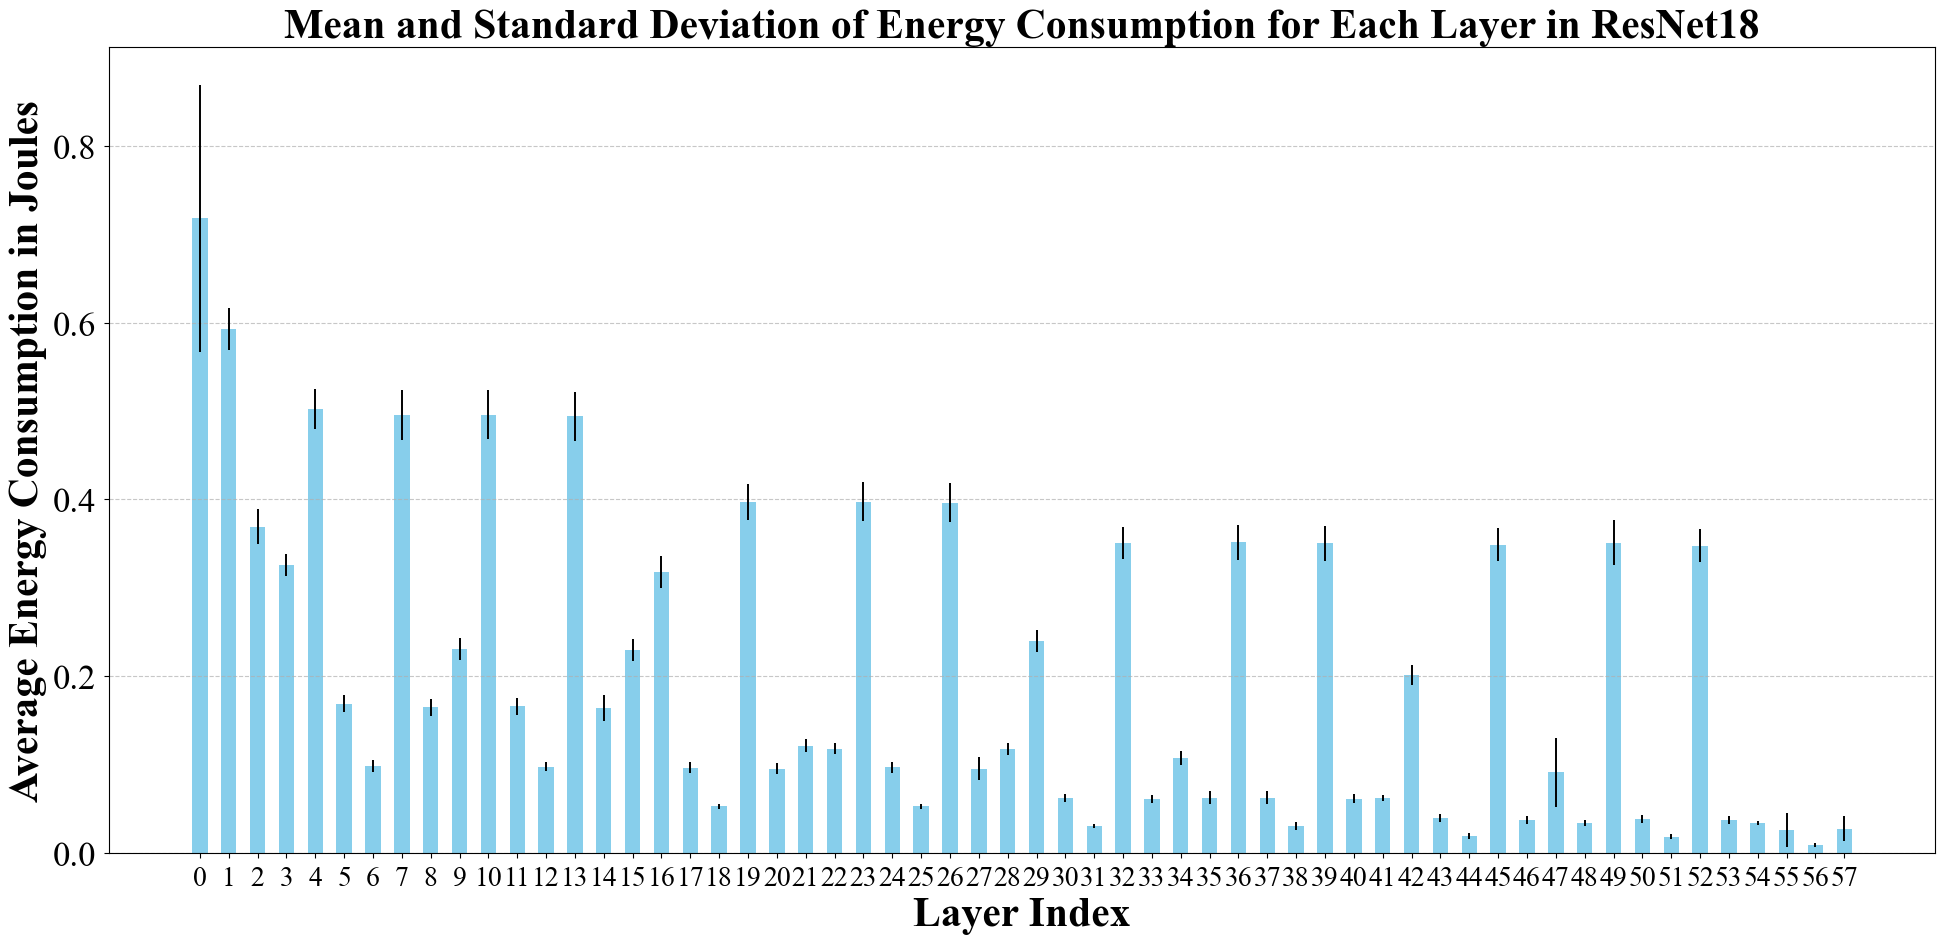

In [23]:
energy_data, labeled_energy_data, forward_layer_energy, \
        to_device, loss, backward, optimize, \
        to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy = load_data(folder_path)

# print('forward_layer_energy:', list(eval(forward_layer_energy.iloc[0][0]).keys()))
print(to_device_energy.shape)

layer_names, layer_energy = get_layer_energy(forward_layer_energy, folder_path)

# plot_energy_data(labeled_energy_data)
# plot_period_energy_data(labeled_energy_data)
# plot_batch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_step_energy_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_step_energy_distribution_bar(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_epoch_step_energy(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_step_time_distribution(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_step_time_distribution_box(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_epoch_step_time(to_device_energy, forward_energy, loss_energy, backward_energy, optimize_energy)
# plot_layer_energy_batch(layer_names, layer_energy)
plot_layer_energy_batch_avgstd(layer_names, layer_energy)